In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jul 26 05:10:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import pandas as pd
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [5]:
import os
# Image library
from PIL import Image

# Rnadom generations lib
import random

In [6]:
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [7]:
import shutil

In [8]:
# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

In [39]:
ROOT_PATH='/content/drive/MyDrive/data'

In [40]:
!pwd

/content/drive/MyDrive


In [41]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/data'

In [23]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'data/train'
valid_path ='data/validation'
test_path='data/test'

In [24]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [25]:
# don't train existing weights
for layer in vgg16.layers:
  print(layer)

In [26]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [27]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
  # useful for getting number of output classes
folders = glob('data/train/*')

In [44]:
folders

[]

In [45]:
len(folders)

0

In [31]:
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [32]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                  horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [34]:
from tensorflow.keras.optimizers import Adam

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [36]:
import matplotlib.pyplot as plt

In [52]:
classes = ['beach','mountain','temple']
train_generator = train_datagen.flow_from_directory(
    os.path.join(ROOT_PATH, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    classes=classes
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(ROOT_PATH, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    classes=classes
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(ROOT_PATH, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

Found 900 images belonging to 3 classes.
Found 216 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [53]:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(validation_generator)
label_map = {v: k for k, v in train_generator.class_indices.items()}

In [54]:
label_map

{0: 'beach', 1: 'mountain', 2: 'temple'}

In [58]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [59]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5",
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   verbose = 1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     verbose = 1)

In [60]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.7767
Epoch 1: val_accuracy improved from -inf to 0.83796, saving model to best_model.h5
29/29 [==============================] - 363s 12s/step - loss: 0.8890 - accuracy: 0.7767 - val_loss: 0.4661 - val_accuracy: 0.8380
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8778
Epoch 2: val_accuracy did not improve from 0.83796
29/29 [==============================] - 121s 4s/step - loss: 0.3068 - accuracy: 0.8778 - val_loss: 0.4526 - val_accuracy: 0.7963
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8978
Epoch 3: val_accuracy improved from 0.83796 to 0.87037, saving model to best_model.h5
29/29 [==============================] - 135s 5s/step - loss: 0.2685 - accuracy: 0.8978 - val_loss: 0.3648 - val_accuracy: 0.8704
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9067
Epoch 4: val_

In [62]:
from tensorflow.keras.utils import plot_model

In [63]:
# Plotly for Data-Viz
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [65]:
# Plotting accuracy and loss
fig = make_subplots(rows=2, cols=1)

# Plot accuracy
fig.add_trace(
    go.Scatter(y=history.history['accuracy'], mode='lines', name='Train Accuracy'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'),
    row=1, col=1
)

# Plot loss
fig.add_trace(
    go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'),
    row=2, col=1
)

fig.update_layout(height=850, width=800, title_text="<b>Accuracy and Loss Over Epochs</b>", template='simple_white')
fig.update_xaxes(title_text='Epochs', row=1)
fig.update_xaxes(title_text='Epochs', row=2)

fig.update_yaxes(title_text='Accuracy', row=1)
fig.update_yaxes(title_text='Loss', row=2)

fig.show(renderer="colab")

In [73]:
model=load_model('best_model.h5')

In [80]:
y_pred=model.predict(validation_generator)

7/7 [==============================] - 28s 4s/step


In [81]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [82]:
y_pred

array([1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0,
       2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2,
       1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 1,
       1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 0,
       1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1,
       1, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 2, 1,
       0, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1,
       2, 0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0])

In [83]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [85]:
model=load_model('best_model.h5')

In [86]:
img=image.load_img('/content/drive/MyDrive/img-20190525-192344-01.jpg',target_size=(224,224))

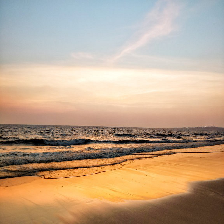

In [87]:
img

In [88]:
x=image.img_to_array(img)
x

array([[[118., 147., 165.],
        [121., 150., 168.],
        [124., 152., 173.],
        ...,
        [140., 168., 182.],
        [138., 166., 180.],
        [137., 165., 179.]],

       [[119., 148., 166.],
        [122., 151., 169.],
        [123., 151., 172.],
        ...,
        [139., 167., 181.],
        [137., 165., 179.],
        [136., 164., 178.]],

       [[119., 148., 166.],
        [121., 150., 168.],
        [126., 154., 175.],
        ...,
        [140., 168., 182.],
        [140., 168., 182.],
        [140., 168., 182.]],

       ...,

       [[136., 102.,  65.],
        [145., 107.,  71.],
        [143., 105.,  68.],
        ...,
        [ 76.,  51.,  31.],
        [ 75.,  50.,  30.],
        [ 76.,  51.,  31.]],

       [[132.,  98.,  61.],
        [136.,  98.,  62.],
        [142., 104.,  67.],
        ...,
        [ 73.,  48.,  28.],
        [ 76.,  51.,  31.],
        [ 71.,  46.,  26.]],

       [[133.,  99.,  62.],
        [139., 101.,  65.],
        [140., 1

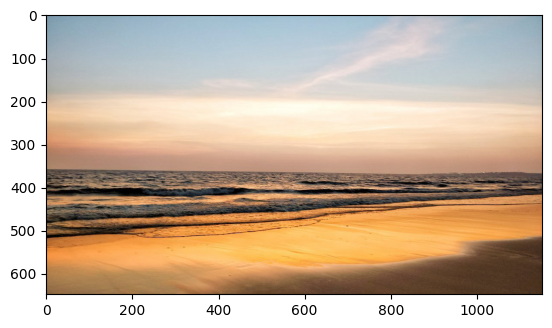

In [89]:
Z = plt.imread('/content/drive/MyDrive/img-20190525-192344-01.jpg')
plt.imshow(Z)

In [90]:
x.shape

(224, 224, 3)

In [91]:
x=x/255

In [92]:
from keras.applications.vgg16 import preprocess_input

In [93]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [94]:
model.predict(img_data)

1/1 [==============================] - 1s 753ms/step


array([[9.9999809e-01, 1.8615300e-06, 1.1657251e-11]], dtype=float32)

In [95]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 22ms/step


In [96]:
a

array([0])

In [97]:
data_set = ['beach','mountain','temple']

In [98]:
data_set[a[0]]

'beach'

In [99]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [100]:
img2=image.load_img('/content/drive/MyDrive/yaopey-yong-IkUnBu-Ewvk-unsplash.jpg',target_size=(224,224))

In [101]:
x2=image.img_to_array(img2)
x2

array([[[247., 251., 250.],
        [250., 251., 253.],
        [250., 251., 253.],
        ...,
        [250., 251., 253.],
        [250., 251., 253.],
        [250., 251., 253.]],

       [[ 59.,  60.,  55.],
        [ 88.,  88.,  76.],
        [227., 234., 227.],
        ...,
        [250., 251., 253.],
        [250., 251., 253.],
        [250., 251., 253.]],

       [[ 50.,  46.,  43.],
        [174., 176., 173.],
        [197., 201., 186.],
        ...,
        [250., 251., 253.],
        [250., 251., 253.],
        [250., 251., 253.]],

       ...,

       [[120.,  89.,  86.],
        [133., 102.,  99.],
        [139., 104., 100.],
        ...,
        [134., 119., 114.],
        [150., 129., 126.],
        [164., 143., 138.]],

       [[126., 115., 109.],
        [120., 109., 103.],
        [116., 105.,  99.],
        ...,
        [161., 126., 120.],
        [153., 123., 115.],
        [154., 129., 122.]],

       [[127., 114., 108.],
        [127., 116., 112.],
        [100.,  

In [102]:
x2.shape

(224, 224, 3)

In [103]:
x2=x2/255

In [104]:
import numpy as np
x2=np.expand_dims(x2,axis=0)
img_data2=preprocess_input(x2)
img_data2.shape

(1, 224, 224, 3)

In [105]:
model.predict(img_data2)

1/1 [==============================] - 0s 31ms/step


array([[9.9999702e-01, 2.9614691e-06, 1.1045191e-11]], dtype=float32)

In [106]:
a2=np.argmax(model.predict(img_data2), axis=1)

1/1 [==============================] - 0s 20ms/step


In [107]:
a2

array([0])

In [108]:
data_set[a2[0]]

'beach'

In [109]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the image dimensions you want to use for ResNet
img_width, img_height = 224, 224

In [ ]:
# Specify the path to the folders containing your images
train_data_dir = '/content/drive/MyDrive/data/train'
validation_data_dir = '/content/drive/MyDrive/data/validation'

In [ ]:
# Set the batch size and number of training and validation samples
batch_size = 32
num_train_samples = 1000  # Set this according to your dataset
num_validation_samples = 300  # Set this according to your dataset

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Rescaling for the validation set (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

In [ ]:
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 855 images belonging to 3 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('data/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 216 images belonging to 3 classes.


In [ ]:
# Load the ResNet50 model without the top layers (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes: temple, mountain, beach

In [ ]:
# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the base ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from keras.applications import resnet
# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)

Epoch 1/15
27/27 [==============================] - 126s 5s/step - loss: 0.6654 - accuracy: 0.6702 - val_loss: 0.6290 - val_accuracy: 0.6296
Epoch 2/15
27/27 [==============================] - 111s 4s/step - loss: 0.6596 - accuracy: 0.6374 - val_loss: 0.6140 - val_accuracy: 0.6157
Epoch 3/15
27/27 [==============================] - 113s 4s/step - loss: 0.6483 - accuracy: 0.6830 - val_loss: 0.5962 - val_accuracy: 0.7407
Epoch 4/15
27/27 [==============================] - 112s 4s/step - loss: 0.6475 - accuracy: 0.7053 - val_loss: 0.6118 - val_accuracy: 0.6389
Epoch 5/15
27/27 [==============================] - 109s 4s/step - loss: 0.6424 - accuracy: 0.6737 - val_loss: 0.6238 - val_accuracy: 0.6296
Epoch 6/15
27/27 [==============================] - 111s 4s/step - loss: 0.6480 - accuracy: 0.6643 - val_loss: 0.6009 - val_accuracy: 0.7361
Epoch 7/15
27/27 [==============================] - 122s 5s/step - loss: 0.6368 - accuracy: 0.7018 - val_loss: 0.6034 - val_accuracy: 0.6204
Epoch 8/15
27

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-5fcde1d712d1>", line 1, in <cell line: 1>
    history = resnet_model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  OSError: [Errno 107] Transport endpoint is not connected: 'data/train/mountain/0AADNFRQDT20.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    